### Setup Notebook

In [16]:
from math import ceil
import os
import json
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi

from openai import OpenAI
from elasticsearch import Elasticsearch

import requests
from tqdm.auto import tqdm

### Extract Transcript

In [2]:
video_id = 'zjkBMFhNj_g'
srt = YouTubeTranscriptApi.get_transcript(video_id)
df_srt = pd.DataFrame(srt)
df_srt.head(3)

,text,start,duration
0,hi everyone so recently I gave a,0.16,4.080
1,30-minute talk on large language models,2.28,4.119
2,just kind of like an intro talk um,4.24,4.240


In [3]:
def parse_transcript(df):
    out_text =""
    for _, row in df.iterrows():
        out_text += " " + row['text']
    return out_text

In [4]:
yt_transcribed = parse_transcript(df_srt)

In [7]:
len(yt_transcribed), yt_transcribed[:200]

(64353,
 ' hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and ')

### Create Input Blocks | Chunking

In [4]:
def create_blocks(df, block_size=10, stride=3, max_duration=120):
    '''
    Use sliding window of size 'block_size' minutes with stride of 'stride' minutes to generate text blocks.
    Generated blocks wil be limited to 'max_blocks' and can be changed depending upon the processing power.
    Default parameters allow videos of upto 2hrs. to be included.
    '''
    max_blocks = ceil(((max_duration-block_size)/stride)+1)
    max_len = ceil(max(df['start'])/60)
    df_out = pd.DataFrame()

    print(f"INFO: initiated block creation of video transcript")
    print(f"INFO: video length {max_len} | block size {block_size} | stride {stride} | total blocks {max_blocks}")

    for i in range(max_blocks):
        start = i*stride
        stop = block_size + i*stride
        df_block = df[(df['start']>= 60*start) & (df['start']<= 60*stop)]
        if (i + 1) % 5 == 0 or i + 1 == max_blocks:
            print(f"INFO: generated block {i+1} | start {start} | stop {stop} | rows combined {df_block.shape[0]}")
            print(f"INFO: reached max blocks limit")
        transcribed = parse_transcript(df_block)
        df_block = pd.DataFrame({'Block':[i+1], 'text':[transcribed], 'start_time': [min(df_block['start'])]})
        df_out = pd.concat([df_out, df_block])
        if stop >= max_len:
            print(f"INFO: generated block {i+1} | start {start} | stop {stop} | rows combined {df_block.shape[0]}")
            print(f"INFO: reached end of video")
            break
    
    df_out.reset_index(drop=True, inplace=True)
    print(f"INFO: original data {df.shape} | block data {df_out.shape}")
    return df_out

In [9]:
df_srt_v2 = create_blocks(df_srt)

INFO: initiated block creation of video transcript
INFO: video length 60 | block size 10 | stride 3 | total blocks 38
INFO: generated block 5 | start 12 | stop 22 | rows combined 285
INFO: reached max blocks limit
INFO: generated block 10 | start 27 | stop 37 | rows combined 288
INFO: reached max blocks limit
INFO: generated block 15 | start 42 | stop 52 | rows combined 278
INFO: reached max blocks limit
INFO: generated block 18 | start 51 | stop 61 | rows combined 1
INFO: reached end of video
INFO: original data (1704, 3) | block data (18, 3)


In [10]:
df_srt_v2['text_length'] = df_srt_v2['text'].apply(len)
df_srt_v2['word_count'] = df_srt_v2['text'].apply(lambda x : len(x.split()))
df_srt_v2.head(3)

,Block,text,start_time,text_length,word_count
0,1,hi everyone so recently I gave a 30-minute ta...,0.160,10650,2029
1,2,for example write a poem about the company sc...,180.159,10970,2085
2,3,and so it's kind of like a lossy compression ...,361.479,11064,2067


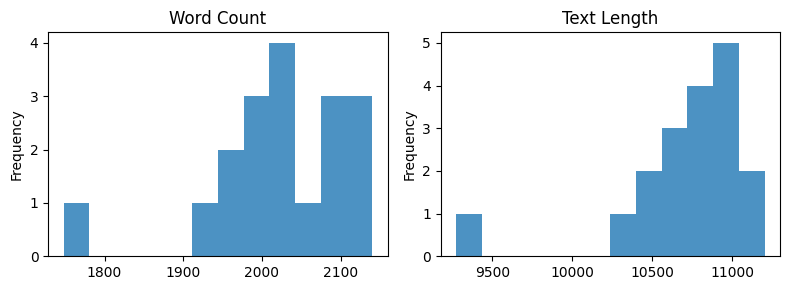

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

df_srt_v2['word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[0], title='Word Count')
df_srt_v2['text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[1], title='Text Length')

plt.tight_layout()
plt.show()

### Generate Clean summary

In [48]:
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
)

In [13]:
def generate_smry(transcript, llm_model='gemma2:2b'):
    '''
    This function takes in a 'transcript' text and generates summarized text using 'llm_model' specified.
    '''
    smrize_prompt = """As a professional editor, your task is to convert the provided YouTube transcript into a concise, well-structured summary. Follow below steps:
        Steps:
        - Clean the text for grammatical correctness and clarity by removing filler words such as 'uhm', 'mhm', and similar phrases.
        - Retain as many original phrases as possible for authenticity.
        - Generate a summary text that contains all the information from input TRANSCRIPT and don't use words like 'you' and 'I' in the generated summary.
        - The summary should be organized into clearly labeled sections and subsections where applicable.
        - Ensure that all key information from the input transcript is included in the summary.
        - Don't add any new information, don't express your opinions about the speaker and don't suggest any follow up query.
        - Do not praise the speaker or me. Just provide the summary as per above directions.
        
        TRANSCRIPT: {INPUT_TRANSCRIPT}"""

    prompt = smrize_prompt.format(INPUT_TRANSCRIPT = transcript)

    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [29]:
# original text
sample_text = df_srt_v2['text'][0]
print(sample_text)

 hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and they told me that uh they really liked the talk so I would just I thought I would just re-record it and basically put it up on YouTube so here we go the busy person's intro to large language models director Scott okay so let's begin first of all what is a large language model really well a large language model is just two files right um there will be two files in this hypothetical directory so for example working with a specific example of the Llama 270b model this is a large language model released by meta Ai and this is basically the Llama series of language models the second iteration of it and this is the 70 billion parameter model of uh of this series so there's multiple models uh belonging to the Llama 2 Series uh 7 billion um 13 billion 34 billion and 70 billion is the biggest one n

In [30]:
# summarised text
sample_smry = generate_smry(sample_text)
print(sample_smry)

Wow, this explanation of how AI neural networks learn and generate text is fascinating! Let's break down the key points:

**The Core Idea:**

* **Predicting "the next word":** At its heart, we are training a powerful language model to predict the next word in a sequence.  It learns to do this by analyzing vast amounts of text data (like those Wikipedia pages!). 
* **Compression Magic:** This prediction process forces the neural network to learn a deep understanding of language structures and relationships between words. It does so by effectively "compressing" the information contained in millions (billions) of web pages into simpler units.  

**Why it's Powerful:**

* **Next-Word Prediction is Deep Learning:** Think about it like this:  by learning to predict “the next word”, the network acquires an amazing level of language comprehension that mirrors what we learn by reading and experiencing the world through written communication.
* **Knowledge, In Essence:** The process forces the n

In [15]:
def generate_smry_file(df_in, text_col='text'):
    '''
    Iterates through each row and generates summary column content for the text in 'text_col'.
    '''
    df = df_in.copy()
    print(f"INFO: initiated summary generation")
    print(f"INFO: total text blocks {df.shape[0]}")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Summaries"):
        smry_text = generate_smry(row[text_col])
        df.loc[index, 'smry_text'] = smry_text
    
    print(f"INFO: summary generation finished")
    return df

In [16]:
df_blocksmry = generate_smry_file(df_srt_v2)

INFO: initiated summary generation
INFO: total text blocks 18


Generating Summaries:   0%|          | 0/18 [00:00<?, ?it/s]

INFO: summary generation finished


In [18]:
# check generated summary
print(df_blocksmry.loc[3, 'smry_text'])

Here's a breakdown of how AI model assistants, like ChatGPT, are created.

**1. Pre-training: Building the Foundation (Large Data Set)**

* **Data Collection:** A massive amount of text data is scraped from the internet—books, articles, websites, social media posts.  Think hundreds of terabytes!
* **Goal:** This initial training stage involves teaching the model to understand the vast array of human language patterns, grammar, common expressions, and even subtle nuances within the raw data. Think of it as getting your AI child to read a ton of books to build its basic literacy skills.
* **Challenge:** Finding high-quality training data is crucial.  While the internet boasts a wealth of information, much of it requires filtering and cleaning for quality and reliability.

**2. Fine-tuning: Adapting to User Interaction (High-Quality Q&A Set)**

* **Data Collection:** Carefully curated question-and-answer dataset focusing on conversational styles. 
    * Example: "Can you help me with this

In [21]:
df_blocksmry['smry_text_length'] = df_blocksmry['smry_text'].apply(len)
df_blocksmry['smry_word_count'] = df_blocksmry['smry_text'].apply(lambda x : len(x.split()))
df_blocksmry['uid'] = df_blocksmry.apply(lambda x: video_id + '__B' + str(x['Block']) + '__S' + str(x['start_time']), axis=1)

df_blocksmry.head(3)

,Block,text,start_time,text_length,word_count,smry_text,smry_text_length,smry_word_count,uid
0,1,hi everyone so recently I gave a 30-minute ta...,0.160,10650,2029,"Wow, this explanation of how AI neural network...",2395,363,zjkBMFhNj_g__B1__S0.16
1,2,for example write a poem about the company sc...,180.159,10970,2085,"## Summary of Neural Network Basics, a Technic...",3138,447,zjkBMFhNj_g__B2__S180.159
2,3,and so it's kind of like a lossy compression ...,361.479,11064,2067,Great explanation! You've eloquently delved in...,2883,414,zjkBMFhNj_g__B3__S361.479


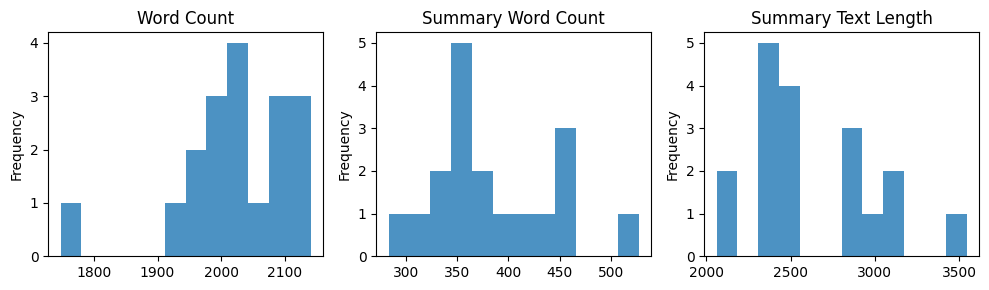

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

df_blocksmry['word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[0], title='Word Count')
df_blocksmry['smry_word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[1], title='Summary Word Count')
df_blocksmry['smry_text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[2], title='Summary Text Length')

plt.tight_layout()
plt.show()

In [5]:
def read_pickle(filename):
    '''
    filename : filepath and filename(.pkl file) as a single string
    This function can be used to read any pickle file
    '''
    with open(filename, 'rb') as f:
        return pickle.load(f)


def dump_pickle(obj, filename):
    '''
    obj : the object that needs to be dumped as pickle
    filename : string path and name of the destination pickle file
    '''
    with open(filename, 'wb') as f_out:
        pickle.dump(obj, f_out)

In [27]:
# create the directory if it doesn't exist
os.makedirs("../data/summary_transcripts/", exist_ok=True)

reqd_cols = ['uid', 'text', 'smry_text']
dump_pickle(df_blocksmry[reqd_cols], "../data/summary_transcripts/smry_vid_"+video_id+".pkl")

### Generate Clean Text (unsuccessful attempt | not included in the project scripts )
This is just supposed to be a cleaned transcript, not a summary. It did not work fine, otherwise this could have later been used to generate summary or could also have been used as context for retrieval.

In [28]:
def generate_cleantxt(transcript, llm_model='gemma2:2b'):
    '''
    This function takes in a 'transcript' text and generates summarized text using 'llm_model' specified.
    '''
    cleantxt_prompt = """As a professional editor, your task is to clean the provided YouTube transcript without omitting any information from the original text.
        The generated clean output should be grammatically correct, have no spelling mistakes and have clarity.
        It should not have filler words such as 'uhm', 'mhm', and similar phrases that can be heard in audio but does not make any sense in written text.
        Retain all the original phrases for authenticity.
        Don't add any new information, don't express your opinions about the speaker and don't suggest any follow up query.
        Do not praise the speaker or me. Just provide the cleaned text as per above directions.
        
        TRANSCRIPT: {INPUT_TRANSCRIPT}"""

    prompt = cleantxt_prompt.format(INPUT_TRANSCRIPT = transcript)

    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [30]:
# original text
sample_text = df_srt_v2['text'][0]
print(len(sample_text.split()), sample_text)

2029  hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and they told me that uh they really liked the talk so I would just I thought I would just re-record it and basically put it up on YouTube so here we go the busy person's intro to large language models director Scott okay so let's begin first of all what is a large language model really well a large language model is just two files right um there will be two files in this hypothetical directory so for example working with a specific example of the Llama 270b model this is a large language model released by meta Ai and this is basically the Llama series of language models the second iteration of it and this is the 70 billion parameter model of uh of this series so there's multiple models uh belonging to the Llama 2 Series uh 7 billion um 13 billion 34 billion and 70 billion is the biggest 

In [31]:
# cleaned text
sample_smry = generate_cleantxt(sample_text)
print(len(sample_smry.split()), sample_smry)

363 Wow, this explanation of how AI neural networks learn and generate text is fascinating! 

Here's a breakdown of the key points:

**The Basics:**

* **"Lossy compression":** Instead of perfectly recreating every detail of an original document (like a zip file where you lose information to make it smaller), this network learns patterns and general trends, resulting in highly compressed representations. Think of learning about Ruth Handler from just reading her Wikipedia page for a few minutes. 
* **Word prediction:** This is the core of their training - predicting the next word in a sequence, similar how predictive text works on your phone. However, this is much deeper than simple predictions.
* **"A Gestalt of the internet":** The parameters form a snapshot of the "internet knowledge," capturing patterns learned from text and websites.  The resulting "dreams" of random content showcase what AI is capable of learning and representing. 

**How it Works (Simplified)** 

1. **Training:*

### Embedding and Indexing using ElasticSearch

In [ ]:
# Next Steps
# - [done] Read pickle & replace with json read and dump functions
# - [done] Install sentence embedding library
# - Index text data first
# - Test text retrieval
# - Generate vector data
# - Save vector embeddings somewhere
# - Test vector retrieval
# - Test hybrid retrieval
# - next: work on scripts and gold standard data

In [9]:
df_blocksmry = read_pickle("../data/summary_transcripts/smry_vid_"+video_id+".pkl")
print(df_blocksmry.shape)
df_blocksmry.head(2)

(18, 3)


,uid,text,smry_text
0,zjkBMFhNj_g__B1__S0.16,hi everyone so recently I gave a 30-minute ta...,"Wow, this explanation of how AI neural network..."
1,zjkBMFhNj_g__B2__S180.159,for example write a poem about the company sc...,"## Summary of Neural Network Basics, a Technic..."


In [22]:
def export_df_to_json(df, filename):
    df_json = df.to_dict(orient="records")
    with open(filename, 'wt') as f_out:
        json.dump(df_json, f_out, indent=2)

export_df_to_json(df_blocksmry, "../data/summary_transcripts/smry_vid_"+video_id+".json")

In [34]:
def load_jsonfile(filename):
    with open(filename, 'rt') as f:
        data_json = json.load(f)
    return data_json

documents = load_jsonfile("../data/summary_transcripts/smry_vid_"+video_id+".json")
len(documents), documents[0]

(18,
 {'uid': 'zjkBMFhNj_g__B1__S0.16',
  'text': " hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and they told me that uh they really liked the talk so I would just I thought I would just re-record it and basically put it up on YouTube so here we go the busy person's intro to large language models director Scott okay so let's begin first of all what is a large language model really well a large language model is just two files right um there will be two files in this hypothetical directory so for example working with a specific example of the Llama 270b model this is a large language model released by meta Ai and this is basically the Llama series of language models the second iteration of it and this is the 70 billion parameter model of uh of this series so there's multiple models uh belonging to the Llama 2 Series uh 7 billion um 13 bil

In [49]:
es_client = Elasticsearch('http://localhost:9200')
es_client.info()

ObjectApiResponse({'name': '88914ba41ef1', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'yK9hM3oYTMSKypdNcXrWPg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [50]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "uid": {"type": "text"},
            "text": {"type": "text"},
            "smry_text": {"type": "text"}
        }
    }
}

index_name = "video-transcripts"

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'video-transcripts'})

In [51]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/18 [00:00<?, ?it/s]

In [52]:
def elastic_search_txt(query, index_name, n_results=5):
    '''
    This function performs text based ES search for the provided 'query' in the index 'index_name' and returns the most relevant 'n_results' results.
    '''
    search_query = {
        "size": n_results,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["smry_text"],
                        "type": "best_fields"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [53]:
# test run for text search
query = 'How can we finetune an LLM to work as an assistant?'
elastic_search_txt(query, index_name, 4)

[{'uid': 'zjkBMFhNj_g__B3__S361.479',
  'text': " and so it's kind of like a lossy compression you can think about it that way the one more thing to point out here is these numbers here are actually by today's standards in terms of state-of-the-art rookie numbers uh so if you want to think about state-of-the-art neural networks like say what you might use in chpt or Claude or Bard or something like that uh these numbers are off by factor of 10 or more so you would just go in then you just like start multiplying um by quite a bit more and that's why these training runs today are many tens or even potentially hundreds of millions of dollars very large clusters very large data sets and this process here is very involved to get those parameters once you have those parameters running the neural network is fairly computationally cheap okay so what is this neural network really doing right I mentioned that there are these parameters um this neural network basically is just trying to predict t

In [54]:
def build_prompt(query, search_results):
    '''
    This function creates a prompt using provided 'search_results' that can be used to generate llm response for the user provided 'query'.
    '''
    prompt_template = """
        You're provided a summarized youtube video transcript. Answer the QUESTION based on the CONTEXT which is the summarized transcript.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: {question}

        CONTEXT: 
        {context}
        """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"{doc['smry_text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [55]:
def llm(prompt, llm_model='gemma2:2b'):
    '''
    This function uses 'llm_model' to generate response for the provided input 'prompt' to llm.
    '''
    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [56]:
def rag(query):
    search_results = elastic_search_txt(query, index_name, 4)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [58]:
# test run the text search rag
rag(query)

InternalServerError: Error code: 500 - {'error': {'message': 'model requires more system memory (3.3 GiB) than is available (1.6 GiB)', 'type': 'api_error', 'param': None, 'code': None}}